In [23]:


import pandas as pd
import os
import torch
import time
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import *

%matplotlib inline



In [24]:
batch_size = 400
epochs = 120
max_lr = 0.001
grad_clip = 0.01
weight_decay =0.001
opt_func = torch.optim.Adam

In [25]:
train_data = torchvision.datasets.CIFAR100('./', train=True, download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()



Files already downloaded and verified


In [40]:
print(np.asarray(train_data[0][0]))

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [195 205 193]
  [212 224 204]
  [182 194 167]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [170 176 150]
  [161 168 130]
  [146 154 113]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [189 199 169]
  [166 178 130]
  [121 133  87]]

 ...

 [[148 185  79]
  [142 182  57]
  [140 179  60]
  ...
  [ 30  17   1]
  [ 65  62  15]
  [ 76  77  20]]

 [[122 157  66]
  [120 155  58]
  [126 160  71]
  ...
  [ 22  16   3]
  [ 97 112  56]
  [141 161  87]]

 [[ 87 122  41]
  [ 88 122  39]
  [101 134  56]
  ...
  [ 34  36  10]
  [105 133  59]
  [138 173  79]]]


In [41]:
print(mean)
print(std)

[0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
[0.26733428587941854, 0.25643846292120615, 0.2761504713263903]


In [28]:
transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean,std)])

In [29]:
trainset = torchvision.datasets.CIFAR100("./",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size, shuffle=True, num_workers=2,pin_memory=True)

testset = torchvision.datasets.CIFAR100("./",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size*2,pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:


trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)



In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        print(images.shape) 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True) 
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028 
                                        nn.Linear(1028, num_classes)) # 1028 -> 100
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, 100), device)
model


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

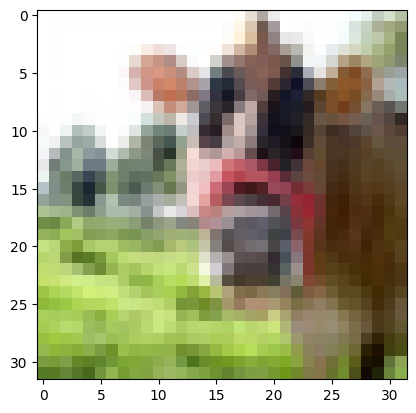

In [38]:
import pylab as plt
from matplotlib import pyplot as plt

plt.imshow(train_data[0][0], interpolation='nearest')
plt.show()

In [34]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:


# Initial evaluation
history = [evaluate(model, testloader)]
history



[{'val_loss': 4.605477333068848, 'val_acc': 0.010192308574914932}]

In [ ]:
# Fitting the first 1/4 epochs
current_time=time.time()
history += fit_one_cycle(int(epochs/4), max_lr, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

In [13]:


# Fitting the second 1/4 epochs
history += fit_one_cycle(int(epochs/4), max_lr/10, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)



Epoch [0], last_lr: 0.00001, train_loss: 0.0458, val_loss: 0.9933, val_acc: 0.7444
Epoch [1], last_lr: 0.00002, train_loss: 0.0443, val_loss: 1.0016, val_acc: 0.7414
Epoch [2], last_lr: 0.00003, train_loss: 0.0446, val_loss: 1.0191, val_acc: 0.7431
Epoch [3], last_lr: 0.00004, train_loss: 0.0447, val_loss: 1.0509, val_acc: 0.7362
Epoch [4], last_lr: 0.00006, train_loss: 0.0539, val_loss: 1.0993, val_acc: 0.7253
Epoch [5], last_lr: 0.00008, train_loss: 0.0679, val_loss: 1.1241, val_acc: 0.7201
Epoch [6], last_lr: 0.00009, train_loss: 0.0833, val_loss: 1.1472, val_acc: 0.7137
Epoch [7], last_lr: 0.00010, train_loss: 0.0956, val_loss: 1.1689, val_acc: 0.7106
Epoch [8], last_lr: 0.00010, train_loss: 0.0976, val_loss: 1.2208, val_acc: 0.7041
Epoch [9], last_lr: 0.00010, train_loss: 0.0924, val_loss: 1.2538, val_acc: 0.7017
Epoch [10], last_lr: 0.00010, train_loss: 0.0826, val_loss: 1.1906, val_acc: 0.7100
Epoch [11], last_lr: 0.00010, train_loss: 0.0745, val_loss: 1.1619, val_acc: 0.7159
Ep

In [14]:


history += fit_one_cycle(int(epochs/8), max_lr/100, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)



Epoch [0], last_lr: 0.00000, train_loss: 0.0083, val_loss: 1.0350, val_acc: 0.7526
Epoch [1], last_lr: 0.00000, train_loss: 0.0083, val_loss: 1.0377, val_acc: 0.7515
Epoch [2], last_lr: 0.00001, train_loss: 0.0085, val_loss: 1.0389, val_acc: 0.7504
Epoch [3], last_lr: 0.00001, train_loss: 0.0093, val_loss: 1.0392, val_acc: 0.7506
Epoch [4], last_lr: 0.00001, train_loss: 0.0092, val_loss: 1.0364, val_acc: 0.7502
Epoch [5], last_lr: 0.00001, train_loss: 0.0087, val_loss: 1.0346, val_acc: 0.7526
Epoch [6], last_lr: 0.00001, train_loss: 0.0098, val_loss: 1.0314, val_acc: 0.7496
Epoch [7], last_lr: 0.00001, train_loss: 0.0091, val_loss: 1.0331, val_acc: 0.7488
Epoch [8], last_lr: 0.00001, train_loss: 0.0085, val_loss: 1.0275, val_acc: 0.7513
Epoch [9], last_lr: 0.00000, train_loss: 0.0079, val_loss: 1.0249, val_acc: 0.7529
Epoch [10], last_lr: 0.00000, train_loss: 0.0075, val_loss: 1.0227, val_acc: 0.7529
Epoch [11], last_lr: 0.00000, train_loss: 0.0073, val_loss: 1.0188, val_acc: 0.7537
Ep

In [15]:


history += fit_one_cycle(int(epochs/8), max_lr/1000, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)



Epoch [0], last_lr: 0.00000, train_loss: 0.0071, val_loss: 1.0191, val_acc: 0.7541
Epoch [1], last_lr: 0.00000, train_loss: 0.0070, val_loss: 1.0189, val_acc: 0.7539
Epoch [2], last_lr: 0.00000, train_loss: 0.0070, val_loss: 1.0191, val_acc: 0.7534
Epoch [3], last_lr: 0.00000, train_loss: 0.0071, val_loss: 1.0190, val_acc: 0.7535
Epoch [4], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0194, val_acc: 0.7534
Epoch [5], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0199, val_acc: 0.7537
Epoch [6], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0197, val_acc: 0.7535
Epoch [7], last_lr: 0.00000, train_loss: 0.0067, val_loss: 1.0194, val_acc: 0.7540
Epoch [8], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0212, val_acc: 0.7525
Epoch [9], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0209, val_acc: 0.7534
Epoch [10], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0177, val_acc: 0.7543
Epoch [11], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0184, val_acc: 0.7530
Ep

In [16]:


history += fit_one_cycle(int(epochs/4), max_lr/100, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
# Print training time
print('Training time: {:.2f} s'.format(time.time() - current_time))



Epoch [0], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0181, val_acc: 0.7526
Epoch [1], last_lr: 0.00000, train_loss: 0.0066, val_loss: 1.0207, val_acc: 0.7541
Epoch [2], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0213, val_acc: 0.7536
Epoch [3], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0221, val_acc: 0.7517
Epoch [4], last_lr: 0.00001, train_loss: 0.0072, val_loss: 1.0186, val_acc: 0.7519
Epoch [5], last_lr: 0.00001, train_loss: 0.0079, val_loss: 1.0219, val_acc: 0.7494
Epoch [6], last_lr: 0.00001, train_loss: 0.0079, val_loss: 1.0212, val_acc: 0.7490
Epoch [7], last_lr: 0.00001, train_loss: 0.0088, val_loss: 1.0230, val_acc: 0.7475
Epoch [8], last_lr: 0.00001, train_loss: 0.0090, val_loss: 1.0231, val_acc: 0.7478
Epoch [9], last_lr: 0.00001, train_loss: 0.0092, val_loss: 1.0194, val_acc: 0.7504
Epoch [10], last_lr: 0.00001, train_loss: 0.0087, val_loss: 1.0190, val_acc: 0.7500
Epoch [11], last_lr: 0.00001, train_loss: 0.0089, val_loss: 1.0251, val_acc: 0.7474
Ep

In [17]:
# Collect training time and result
current_time = time.time()
result = evaluate(model, testloader)
result
print('Training time: {:.2f} s'.format(time.time() - current_time))

Training time: 1.42 s


In [18]:
# Saving the model to h5 file
torch.save(model.state_dict(), 'group22_pretrained_model.h5')

In [19]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

y_test, y_pred = test_label_predictions(model, device, testloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

Confusion matrix:
[[90  0  0 ...  0  1  0]
 [ 1 88  0 ...  0  0  0]
 [ 0  1 65 ...  0  4  0]
 ...
 [ 0  0  0 ... 87  1  0]
 [ 0  1  3 ...  0 58  0]
 [ 0  0  1 ...  0  0 74]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       100
           1       0.83      0.88      0.85       100
           2       0.65      0.65      0.65       100
           3       0.64      0.58      0.61       100
           4       0.54      0.64      0.59       100
           5       0.71      0.76      0.73       100
           6       0.77      0.85      0.81       100
           7       0.85      0.82      0.83       100
           8       0.91      0.86      0.89       100
           9       0.89      0.85      0.87       100
          10       0.60      0.56      0.58       100
          11       0.60      0.55      0.57       100
          12       0.76      0.80      0.78       100
          13       0.67      0.62      0.65       100
          14   

In [24]:
from torchsummary import summary

print(summary(model,(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,